# Practice GNN

## Notebook configuration

In [ ]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import ipywidgets as widgets
import os
import sys
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
from tqdm import trange
from IPython import get_ipython
from IPython.display import display
from time import monotonic
from pprint import pprint
from google.colab import drive
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, Sequential, Linear, ReLU
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter torch-sparse pyg-lib torch-geometric \
  -f https://data.pyg.org/whl/torch-2.5.1+cu118.html

# !pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install torch-scatter torch-sparse pyg-lib torch-geometric -f https://data.pyg.org/whl/torch-2.5.1+cpu.html

from torch_geometric.nn import GINEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, LinkNeighborLoader
!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAveragePrecision
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

content_base = "/content/drive"
drive.mount(content_base)

# Project data
data_dir = os.path.join(content_base, "My Drive/Capstone/data")
data_file = os.path.join(data_dir, "subset_transactions2.csv")

Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu118.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 13.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Google Colaboratory executes in an environment with a file system
# that has a Linux topography, but where the user should work under
# the `/content` directory
COLAB_ROOT = "/content"

REPO_URL = "https://github.com/engie4800/dsi-capstone-spring-2025-TD-anti-money-laundering.git"
REPO_ROOT = os.path.join(COLAB_ROOT, REPO_URL.split("/")[-1].split(".")[0])
REPO_BRANCH = "sophie"

# Clones the repository at `/content/dsi-capstone-spring-2025-TD-anti-money-laundering`
if not os.path.exists(REPO_ROOT):
  os.chdir(COLAB_ROOT)
  !git clone {REPO_URL}

# Pulls the latest code from the provided branch and adds the
# analysis pipeline source code to the Python system path
os.chdir(REPO_ROOT)
!git pull
!git checkout {REPO_BRANCH}
sys.path.append(os.path.join(REPO_ROOT, "Code/src"))
os.chdir(COLAB_ROOT)

from helpers import add_cell_timer
from pipeline import ModelPipeline
add_cell_timer()

Cloning into 'dsi-capstone-spring-2025-TD-anti-money-laundering'...
remote: Enumerating objects: 765, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 765 (delta 142), reused 126 (delta 80), pack-reused 529 (from 2)
Receiving objects: 100% (765/765), 63.46 MiB | 47.47 MiB/s, done.
Resolving deltas: 100% (406/406), done.
Already up to date.
Branch 'sophie' set up to track remote branch 'sophie' from 'origin'.
Switched to a new branch 'sophie'


## Data preprocessing

Run initial full-dataset preprocessing

In [ ]:
def create_unique_ids(pl):
    """Create unique account - ID mapping."""
    print("Creating unique ids...")
    if not pl.preprocessed["renamed"]:
        raise RuntimeError("Columns must be renamed (run rename()) before creating unique IDs.")

    # Sort transactions by timestamp first
    pl.df = pl.df.sort_values(by='timestamp_int').reset_index(drop=True)
    pl.df['edge_id'] = pl.df.index.astype(int)

    # Get unique account-bank combos (a couple of acct numbers found at multiple banks)
    pl.df['from_account_id'] = pl.df['from_bank'].astype(str) + '_' + pl.df['from_account'].astype(str)
    pl.df['to_account_id'] = pl.df['to_bank'].astype(str) + '_' + pl.df['to_account'].astype(str)
    pl.df.drop(columns=["from_account", "to_account"], inplace=True)

    # Combine all accounts in the order they appear, preserving timestamp order
    accounts_ordered = pd.concat([
        pl.df[["edge_id", "from_account_id"]].rename(columns={"from_account_id": "account_id"}),
        pl.df[["edge_id", "to_account_id"]].rename(columns={"to_account_id": "account_id"})
    ])

    # Sort by timestamp to reflect temporal ordering
    accounts_ordered = accounts_ordered.sort_values(by='edge_id')

    # Drop duplicates to get first-seen ordering of accounts
    unique_accounts = accounts_ordered.drop_duplicates(subset="account_id")["account_id"].reset_index(drop=True)

    # Create mapping: account_id → index based on first appearance
    node_mapping = {account: idx for idx, account in enumerate(unique_accounts)}

    # Map node identifiers to integer indices
    pl.df["from_account_idx"] = pl.df["from_account_id"].map(node_mapping)
    pl.df["to_account_idx"] = pl.df["to_account_id"].map(node_mapping)

    pl.preprocessed["unique_ids_created"] = True


⏱️ Execution time: 0.0s


In [ ]:
def add_currency_change_feature(pl):
    pl.df['currency_changed'] = (pl.df['sent_currency'] != pl.df['received_currency']).astype(int)


⏱️ Execution time: 0.0s


In [ ]:
pl = ModelPipeline(data_file)
pl.rename_columns()
pl.drop_duplicates()
pl.extract_time_features()
create_unique_ids(pl)
add_currency_change_feature(pl)
pl.currency_normalization()
pl.cyclical_encoding()
pl.binary_weekend()
pl.apply_label_encoding()
pl.apply_one_hot_encoding()

Extracting time features...

Creating unique ids...


Normalizing currency...

Adding cyclical encoding to time feats...

Applying label encoding...

Label encoding applied to columns: ['day_of_week', 'from_bank', 'to_bank']

Applying one hot encoding...

One hot encoding applied to columns: ['payment_type', 'received_currency', 'sent_currency']


⏱️ Execution time: 28.17s


In [ ]:
pl.df.columns

Index(['from_bank', 'to_bank', 'received_amount', 'sent_amount',
       'is_laundering', 'hour_of_day', 'day_of_week', 'seconds_since_midnight',
       'timestamp_int', 'timestamp_scaled', 'edge_id', 'from_account_id',
       'to_account_id', 'from_account_idx', 'to_account_idx',
       'currency_changed', 'sent_amount_usd', 'received_amount_usd', 'day_sin',
       'day_cos', 'time_of_day_sin', 'time_of_day_cos', 'is_weekend',
       'received_currency_Australian Dollar', 'received_currency_Bitcoin',
       'received_currency_Brazil Real', 'received_currency_Canadian Dollar',
       'received_currency_Euro', 'received_currency_Mexican Peso',
       'received_currency_Ruble', 'received_currency_Rupee',
       'received_currency_Saudi Riyal', 'received_currency_Shekel',
       'received_currency_Swiss Franc', 'received_currency_UK Pound',
       'received_currency_US Dollar', 'received_currency_Yen',
       'received_currency_Yuan', 'sent_currency_Australian Dollar',
       'sent_currenc


⏱️ Execution time: 0.0s


In [ ]:
pl.df[['from_account_idx','to_account_idx']].head()

,from_account_idx,to_account_idx
0,0,1
1,2,2
2,3,4
3,5,5
4,6,6



⏱️ Execution time: 0.02s


## Time txn feats

In [ ]:
def get_time_diff_from(pl):
  # Ensure data is sorted by timestamp
  pl.df = pl.df.sort_values(by=["from_account_idx", "timestamp_int"]).reset_index(drop=True)

  # Group by account and compute time difference from previous transaction
  pl.df["time_diff_from"] = pl.df.groupby("from_account_idx")["timestamp_int"].diff()
  pl.df["time_diff_from"] = pl.df["time_diff_from"].fillna(-1)

  pl.df = pl.df.sort_values(by='edge_id').reset_index(drop=True)


⏱️ Execution time: 0.0s


In [ ]:
def get_turnaround_time(pl):
  # Keep track of last received timestamp per account
    last_received_time = {}

    turnaround_times = []

    for _, row in pl.df.iterrows():
        from_id = row["from_account_idx"]
        to_id = row["to_account_idx"]
        timestamp = row["timestamp_int"]

        # Compute turnaround if account had received money earlier
        turnaround_time = timestamp - last_received_time.get(from_id, np.nan)
        turnaround_times.append(turnaround_time)

        # Update last received time for the destination
        last_received_time[to_id] = timestamp

    pl.df["turnaround_time"] = turnaround_times
    pl.df["turnaround_time"] = pl.df["turnaround_time"].fillna(-1)  # optional



⏱️ Execution time: 0.0s


In [ ]:
get_time_diff_from(pl)
get_turnaround_time(pl)


⏱️ Execution time: 52.92s


### Train test split (fold)

In [ ]:
def split_train_test_val(pl, X_cols, y_col, test_size=0.15, val_size=0.15, split_type="random_stratified"):
    """Perform Train-Test-Validation Split
        OPTIONS: ["random_stratified", "temporal", "temporal_agg"]
        "random stratified": Data is randomized and split while keeping `is_laundering` label proportionate bt train/val/test.
        "temporal": Data is sorted by timestamp, and split into df[:t1], df[t1:t2], df[t2:]
        "temporal_agg": Data is sorted by timestamp and split into df[:t1], df[:t2], df[:].
            Note that in GNN, need to mask labels s.t. val only evaluates df[t1:t2] labels and test only evaluates df[t2:] labels.
    """
    valid_splits = ["random_stratified", "temporal", "temporal_agg"]

    if split_type is None:
        print("No split type entered; using default split_type: 'random_stratified'")
        print("Valid split_type options:\n"
            "- 'random_stratified' → Stratified random split maintaining label balance.\n"
            "- 'temporal' → Sequential split based on timestamps.\n"
            "- 'temporal_agg' → Aggregated sequential split (masking required in GNN evaluation).\n"
            "See `split_train_test_val` for more details."
        )
        split_type = "random_stratified"

    elif split_type not in valid_splits:
        raise ValueError(
            f"Invalid split_type: '{split_type}'.\n"
            f"Expected one of {valid_splits}.\n"
            "Please choose a valid option:\n"
            "- 'random_stratified' → Stratified random split maintaining label balance.\n"
            "- 'temporal' → Sequential split based on timestamps.\n"
            "- 'temporal_agg' → Aggregated sequential split with masking required in GNN evaluation.\n"
            "See `split_train_test_val` for more details."
        )

    pl.split_type = split_type

    if split_type == "random_stratified":
        X = pl.df[X_cols]
        y = pl.df[y_col]

        pl.X_train, X_temp, pl.y_train, y_temp = train_test_split(
            X, y, test_size=(test_size + val_size), random_state=42, stratify=y
        )
        pl.X_val, pl.X_test, pl.y_val, pl.y_test = train_test_split(
            X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42, stratify=y_temp
        )

    elif split_type == "temporal":
        if "timestamp_int" not in pl.df.columns:
            raise RuntimeError("Need `timestamp_int` in df for temporal split. Review preprocessing steps.")

        # Sort by time and find indices for data split
        df_sorted = pl.df.sort_values(by=["timestamp_int"])
        X = df_sorted[X_cols]
        y = df_sorted[y_col]
        t1 = int((1-(test_size+val_size))*len(pl.df))
        t2 = int((1-test_size)*len(pl.df))

        # Split databased on timestamp
        pl.X_train, pl.y_train = X[:t1], y[:t1]
        pl.X_val, pl.y_val = X[t1:t2], y[t1:t2]
        pl.X_test, pl.y_test = X[t2:], y[t2:]

    elif split_type == "temporal_agg":
        if "timestamp_int" not in pl.df.columns:
            raise RuntimeError("Must include timestamp_int in df for temporal split")

        if "edge_id" not in pl.df.columns:
            raise RuntimeError("Must include edge_id in df for temporal split")

        # Sort by time and find indices for data split
        X = pl.df[X_cols]
        y = pl.df[y_col]
        t1 = int((1-(test_size+val_size))*len(pl.df))
        t2 = int((1-test_size)*len(pl.df))

        # Temporal aggregated split (keeps earlier data but masks during GNN loss computation)
        pl.X_train, pl.y_train = X[:t1], y[:t1]
        pl.X_val, pl.y_val = X[:t2], y[:t2]
        pl.X_test, pl.y_test = X[:], y[:]

    print(f"Data split using {split_type} method.")
    if split_type == "temporal_agg":
        print("Remember to mask labels in GNN evaluation.\n"
              " - Train: no mask \n"
              " - Val: mask y_lab[:t1] (only evaluate labels y_lab[t1:t2]) \n"
              " - Test: mask y_lab[:t2] (only evaluate labels y_lab[t2:])")

    return pl.X_train, pl.X_val, pl.X_test, pl.y_train, pl.y_val, pl.y_test


⏱️ Execution time: 0.0s


In [ ]:
X_cols = ['edge_id', 'from_account_idx', 'to_account_idx', 'received_amount', 'sent_amount',
       'is_laundering', 'from_account_idx','to_account_idx', 'sent_amount_usd', 'received_amount_usd',
        'timestamp_int', 'timestamp_scaled', 'day_sin', 'day_cos', 'time_of_day_sin',
       'time_of_day_cos', 'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoin',
       'sent_currency_Brazil Real', 'sent_currency_Canadian Dollar',
       'sent_currency_Euro', 'sent_currency_Mexican Peso',
       'sent_currency_Ruble', 'sent_currency_Rupee',
       'sent_currency_Saudi Riyal', 'sent_currency_Shekel',
       'sent_currency_Swiss Franc', 'sent_currency_UK Pound',
       'sent_currency_US Dollar', 'sent_currency_Yen', 'sent_currency_Yuan',
       'payment_type_ACH', 'payment_type_Bitcoin', 'payment_type_Cash',
       'payment_type_Cheque', 'payment_type_Credit Card',
       'payment_type_Reinvestment', 'payment_type_Wire']
y_cols = ['is_laundering']


⏱️ Execution time: 0.0s


In [ ]:
# pl.df.sort_values(by='edge_id', inplace=True)
# X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(pl, X_cols, y_cols, split_type="temporal_agg")

Data split using temporal_agg method.
Remember to mask labels in GNN evaluation.
 - Train: no mask 
 - Val: mask y_lab[:t1] (only evaluate labels y_lab[t1:t2]) 
 - Test: mask y_lab[:t2] (only evaluate labels y_lab[t2:])

⏱️ Execution time: 0.78s


### Get train test indices

In [ ]:
def return_split_indices(pl, val_size, test_size):
  """ Returns numpy arrays of appropriate indices based on val and test sizes """
  num_edges = len(pl.df)
  t1 = int(num_edges * (1 - val_size - test_size))
  t2 = int(num_edges * (1 - test_size))
  tr_inds = np.arange(0, t1)
  val_inds = np.arange(t1, t2)
  te_inds = np.arange(t2, num_edges)
  tr_val_inds = np.concat([tr_inds, val_inds])
  tr_val_te_inds = np.concat([tr_val_inds, te_inds])
  return t1, t2, tr_inds, val_inds, te_inds, tr_val_inds, tr_val_te_inds


⏱️ Execution time: 0.0s


In [ ]:
t1, t2, tr_inds, val_inds, te_inds, tr_val_inds, tr_val_te_inds = return_split_indices(pl, 0.15, 0.15)
print(t1, t2)

875630 1063265

⏱️ Execution time: 0.01s


### Compute node features per split

In [ ]:
import networkx as nx
def compute_split_specific_node_features(pl, split_name: str, inds, graph_features: list[str] = ["sent_amount_usd"]):
    """
    Compute node features for a specific split using from_account_idx and to_account_idx as node identifiers.
    """
    print(f"Computing {split_name} node features...")

    # Extract subset of edges in the split
    split_edges = pl.df.loc[inds, :]

    # Aggregate edges by from-to pairs
    aggregated_edges = (
        split_edges
        .groupby(["from_account_idx", "to_account_idx"])[graph_features]
        .sum()
        .reset_index()
    )

    # Build directed graph using account indices as node ids
    G = nx.DiGraph()
    for _, row in aggregated_edges.iterrows():
        G.add_edge(
            int(row["from_account_idx"]),
            int(row["to_account_idx"]),
            **{col: row[col] for col in graph_features}
        )

    # Compute graph features using account index as node_id
    degree_centrality = nx.degree_centrality(G)
    in_deg = {n: d / (len(G) - 1) for n, d in G.in_degree()}
    out_deg = {n: d / (len(G) - 1) for n, d in G.out_degree()}
    pagerank = nx.pagerank(G, weight="sent_amount_usd")

    # Collect into DataFrame
    node_df = pd.DataFrame({"node_id": list(G.nodes)})
    node_df["degree_centrality"] = node_df["node_id"].map(degree_centrality)
    node_df["in_degree"] = node_df["node_id"].map(in_deg)
    node_df["out_degree"] = node_df["node_id"].map(out_deg)
    node_df["pagerank"] = node_df["node_id"].map(pagerank)

    # Ensure completeness and ordering
    node_df.fillna(0, inplace=True)
    node_df = node_df.sort_values("node_id").reset_index(drop=True)

    print(f"Computed node features for {split_name} with {len(node_df)} nodes.")
    return node_df


⏱️ Execution time: 0.0s


In [ ]:
# Assign node features per split to avoid leakage
pl.train_nodes = compute_split_specific_node_features(pl, "train", tr_inds)
pl.val_nodes = compute_split_specific_node_features(pl, "val", tr_val_inds)
pl.test_nodes = compute_split_specific_node_features(pl, "test", tr_val_te_inds)

Computing train node features...
Computed node features for train with 107090 nodes.
Computing val node features...
Computed node features for val with 107355 nodes.
Computing test node features...
Computed node features for test with 107583 nodes.

⏱️ Execution time: 26.78s


In [ ]:
pl.train_nodes.head(10)

,node_id,degree_centrality,in_degree,out_degree,pagerank
0,0,0.039108,0.005089,0.034018,0.000720
1,1,0.000028,0.000019,0.000009,0.000002
2,2,0.000028,0.000009,0.000019,0.000009
3,3,0.000047,0.000028,0.000019,0.000006
4,4,0.000047,0.000037,0.000009,0.000046
5,5,0.000047,0.000019,0.000028,0.000002
6,6,0.000093,0.000075,0.000019,0.000089
7,7,0.000037,0.000019,0.000019,0.000003
8,8,0.000037,0.000019,0.000019,0.000002
9,9,0.000233,0.000149,0.000084,0.000046



⏱️ Execution time: 0.01s


In [ ]:
pl.val_nodes.head(10)

,node_id,degree_centrality,in_degree,out_degree,pagerank
0,0,0.039011,0.005077,0.033934,0.000706
1,1,0.000028,0.000019,0.000009,0.000002
2,2,0.000028,0.000009,0.000019,0.000009
3,3,0.000047,0.000028,0.000019,0.000005
4,4,0.000047,0.000037,0.000009,0.000046
5,5,0.000047,0.000019,0.000028,0.000002
6,6,0.000093,0.000075,0.000019,0.000077
7,7,0.000037,0.000019,0.000019,0.000003
8,8,0.000037,0.000019,0.000019,0.000002
9,9,0.000298,0.000149,0.000149,0.000047



⏱️ Execution time: 0.01s


In [ ]:
# pl.extract_nodes()
# print(pl.nodes.columns)

Extracting nodes...

Creating a Data Frame containing 107583 nodes

Index(['node_id', 'placeholder'], dtype='object')

⏱️ Execution time: 0.01s


### Create train val test graph objects

In [ ]:
def split_train_test_val_graph(pl, edge_features=None, val_size=0.15, test_size=0.15):
  if edge_features is None:
    edge_features = ['edge_id', 'sent_amount_usd', 'received_amount_usd',
        'timestamp_scaled','time_diff_from', 'turnaround_time',
       'day_sin', 'day_cos', 'time_of_day_sin', 'time_of_day_cos',
        'payment_type_ACH', 'currency_changed', 'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoin',
       'sent_currency_Brazil Real', 'sent_currency_Canadian Dollar',
       'sent_currency_Euro', 'sent_currency_Mexican Peso',
       'sent_currency_Ruble', 'sent_currency_Rupee',
       'sent_currency_Saudi Riyal', 'sent_currency_Shekel',
       'sent_currency_Swiss Franc', 'sent_currency_UK Pound',
       'sent_currency_US Dollar', 'sent_currency_Yen', 'sent_currency_Yuan']

  # Nodes
  tr_x = torch.tensor(pl.train_nodes.drop(columns='node_id').values, dtype=torch.float)
  val_x = torch.tensor(pl.val_nodes.drop(columns='node_id').values, dtype=torch.float)
  te_x = torch.tensor(pl.test_nodes.drop(columns='node_id').values, dtype=torch.float)

  # Labels
  y = torch.LongTensor(pl.df['is_laundering'].to_numpy())

  # Edge index
  edge_index = torch.LongTensor(pl.df[['from_account_idx', 'to_account_idx']].to_numpy().T)

  # Edge attr
  edge_attr = torch.tensor(pl.df[edge_features].to_numpy(), dtype=torch.float)

  t1, t2, tr_inds, val_inds, te_inds, tr_val_inds, tr_val_te_inds = return_split_indices(pl, 0.2, 0.2)
  t1 = torch.tensor(t1)
  t2 = torch.tensor(t2)
  tr_inds = torch.tensor(tr_inds)
  val_inds = torch.tensor(val_inds)
  te_inds = torch.tensor(te_inds)

  cat_tr_val_inds = torch.cat((tr_inds, val_inds))
  tr_data = Data(x=tr_x, edge_index=edge_index[:,tr_inds], edge_attr=edge_attr[tr_inds], y=y[tr_inds])
  val_data = Data(x=val_x, edge_index=edge_index[:,cat_tr_val_inds], edge_attr=edge_attr[cat_tr_val_inds], y=y[cat_tr_val_inds])
  te_data = Data(x=te_x, edge_index=edge_index, edge_attr=edge_attr, y=y)

  return tr_inds, val_inds, te_inds, tr_data, val_data, te_data, edge_index, y


⏱️ Execution time: 0.0s


In [ ]:
edge_features = ['edge_id', 'sent_amount_usd', 'received_amount_usd','timestamp_scaled',
       'time_diff_from', 'turnaround_time', 'day_sin', 'day_cos', 'time_of_day_sin',
       'time_of_day_cos', 'payment_type_ACH', 'payment_type_Wire', 'payment_type_Bitcoin',
                 'payment_type_Cash', 'payment_type_Cheque', 'payment_type_Credit Card',
                 'payment_type_Reinvestment',
        'currency_changed',
         'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoin',
       'sent_currency_Brazil Real', 'sent_currency_Canadian Dollar',
       'sent_currency_Euro', 'sent_currency_Mexican Peso',
       'sent_currency_Ruble', 'sent_currency_Rupee',
       'sent_currency_Saudi Riyal', 'sent_currency_Shekel',
       'sent_currency_Swiss Franc', 'sent_currency_UK Pound',
       'sent_currency_US Dollar', 'sent_currency_Yen', 'sent_currency_Yuan']
tr_inds, val_inds, te_inds, tr_data, val_data, te_data, edge_index, y = split_train_test_val_graph(pl, edge_features)


⏱️ Execution time: 0.6s


### Create data loaders with `LinkNeighborLoader`
Goal: Create data loaders - split into batches using `LinkNeighborLoader`, incorporating masking in the loading process & batching

**LinkNeighborLoader:**

**num_neighbors:** how many neighbors are sampled per node -- only sampling a subgraph around each edge in a batch. it is size [x,y] because we have 2 layers (sample x nodes in layer 1 and y nodes in layer 2).
- Let’s say your batch contains 100 edges, and each edge touches two nodes (source and destination). Then LinkNeighborLoader will:
  - Identify all unique nodes from those 100 edges
  - For each of those nodes:
      - Sample 10 neighbors (for layer 1)
      - Then, for each of those neighbors, sample another 10 neighbors (for layer 2)
  - Build a mini subgraph for this batch using only those sampled nodes and edges
- Imagine you're doing link prediction for a social network:
  - batch_size = 1024 means you're analyzing 1024 friend requests at a time
  - num_neighbors = [10, 10] means for each person in the request, you look at:
    - Their 10 direct friends
    - And 10 friends-of-friends per direct friend

In [ ]:
from sklearn.preprocessing import StandardScaler
def scale_data(data, cols_to_scale):
  edge_attr_cpu = data.edge_attr.cpu().numpy()

  for col in cols_to_scale:
    col_data = edge_attr_cpu[:, col]
    col_data = col_data.copy()

    # Mask to identify valid (non -1) values
    mask = col_data != -1
    if np.sum(mask) == 0:
        continue  # skip column if all are -1

    # Median impute and scale
    median_val = np.median(col_data[mask])
    col_data[~mask] = median_val
    edge_attr_cpu[:, col] = StandardScaler().fit_transform(col_data.reshape(-1, 1)).flatten()

  data.edge_attr = torch.from_numpy(edge_attr_cpu).float().to(device)
  data.x = data.x.to(device)
  data.y = data.y.to(device)
  return data

def get_data_loaders(tr_data, val_data, te_data, tr_inds, val_inds, te_inds, edge_index, y, num_neighbors=[100,100], batch_size=8192):

  # Standard scale on CPU before sending to device
  tr_data = scale_data(tr_data, [1, 2, 3, 4, 5])
  val_data = scale_data(val_data, [1, 2, 3, 4, 5])
  te_data = scale_data(te_data, [1, 2, 3, 4, 5])


  tr_loader = LinkNeighborLoader(
      data=tr_data,
      edge_label_index=edge_index[:, tr_inds],
      edge_label=y[tr_inds],
      batch_size=batch_size,
      num_neighbors=num_neighbors,
      shuffle=True
  )

  val_loader = LinkNeighborLoader(
      data=val_data,
      edge_label_index=edge_index[:, val_inds],
      edge_label=y[val_inds],
      batch_size=batch_size,
      num_neighbors=num_neighbors,
      shuffle=False
  )

  te_loader = LinkNeighborLoader(
      data=te_data,
      edge_label_index=edge_index[:, te_inds],
      edge_label=y[te_inds],
      batch_size=batch_size,
      num_neighbors=num_neighbors,
      shuffle=False
  )

  return tr_loader, val_loader, te_loader, tr_data, val_data, te_data


⏱️ Execution time: 0.0s


In [ ]:
# If on GPU, do as below
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda

⏱️ Execution time: 0.0s


In [ ]:
tr_loader, val_loader, te_loader, tr_data, val_data, te_data = get_data_loaders(tr_data, val_data, te_data, tr_inds, val_inds, te_inds, edge_index, y)


⏱️ Execution time: 1.04s


In [ ]:
train_edge_nodes = edge_index[:, tr_inds].flatten().unique()
print("Unique node count in training edges:", train_edge_nodes.numel())

Unique node count in training edges: 106913

⏱️ Execution time: 0.05s


In [ ]:
len(pl.train_nodes)

107090


⏱️ Execution time: 0.0s


In [ ]:
tr_data.x.shape

torch.Size([107090, 4])


⏱️ Execution time: 0.0s


## GNNs

Cannot use GCN or GAT!

* The Graph Convolutional Network (GCN), implemented with `GCNConv`, only aggregates features from neighboring nodes and does not use edge attributes in its message passing.
* Graph Attention Networks (GAT), implemented with `GATConv`, allows edge attention weights, which can indirectly incorporate edge attributes. Problem: If all nodes have the same feature vector (e.g., initialized to 1), then the computed attention scores will be the same for all edges. We'd need to modify GAT to use edge features meaningfully in the attention computation.

`GINeConv`
* Directly includes edge attributes in message passing using an MLP-based edge transformation.

`EdgeConv`
* dynamically computes edge embeddings and updates node features based on edges

**We'll be using GINeConv moving forward.**

### Model

In [ ]:
from torch.nn import BatchNorm1d as BatchNorm

class GINe(torch.nn.Module):
    def __init__(self, n_node_feats, n_edge_feats, num_gnn_layers=2, n_classes=1,
                n_hidden=100, edge_updates=True, residual=True,
                dropout=0.0, final_dropout=0.10527690625126304):
        super().__init__()
        self.n_hidden = n_hidden
        self.num_gnn_layers = num_gnn_layers
        self.edge_updates = edge_updates
        self.final_dropout = final_dropout

        self.node_emb = nn.Linear(n_node_feats, n_hidden)
        self.edge_emb = nn.Linear(n_edge_feats, n_hidden)

        self.convs = nn.ModuleList()
        self.emlps = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for _ in range(self.num_gnn_layers):
            conv = GINEConv(nn.Sequential(
                nn.Linear(self.n_hidden, self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, self.n_hidden)
                ), edge_dim=self.n_hidden)

            if self.edge_updates: self.emlps.append(nn.Sequential(
                nn.Linear(3 * self.n_hidden, self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, self.n_hidden),
            ))
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(n_hidden))

        self.mlp = nn.Sequential(Linear(n_hidden*3, 50), nn.ReLU(), nn.Dropout(self.final_dropout),Linear(50, 25), nn.ReLU(), nn.Dropout(self.final_dropout),
                              Linear(25, n_classes))

    def forward(self, x, edge_index, edge_attr):
        src, dst = edge_index

        x = self.node_emb(x)
        edge_attr = self.edge_emb(edge_attr)

        for i in range(self.num_gnn_layers):

            # Node update
            x_res = self.convs[i](x, edge_index, edge_attr)
            x = (x + F.relu(self.batch_norms[i](x_res))) / 2

            # Edge update
            if self.edge_updates:
                edge_input = torch.cat([x[src], x[dst], edge_attr], dim=-1)
                edge_attr = edge_attr + self.emlps[i](edge_input) / 2

        # Final prediction
        x_edge = torch.cat([x[src], x[dst], edge_attr], dim=-1)
        return self.mlp(x_edge).squeeze(-1)


⏱️ Execution time: 0.0s


#### Fold

In [ ]:
from torch.nn import BatchNorm1d as BatchNorm

class GINe_Debug(torch.nn.Module):
    def __init__(self, num_features, num_gnn_layers=2, n_classes=1,
                n_hidden=100, edge_updates=True, residual=True,
                edge_dim=None, dropout=0.0, final_dropout=0.10527690625126304):
        super().__init__()
        self.n_hidden = n_hidden
        self.num_gnn_layers = num_gnn_layers
        self.edge_updates = edge_updates
        self.final_dropout = final_dropout

        self.node_emb = nn.Linear(num_features, n_hidden)
        self.edge_emb = nn.Linear(edge_dim, n_hidden)

        self.convs = nn.ModuleList()
        self.emlps = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for _ in range(self.num_gnn_layers):
            conv = GINEConv(nn.Sequential(
                nn.Linear(self.n_hidden, self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, self.n_hidden)
                ), edge_dim=self.n_hidden)

            if self.edge_updates: self.emlps.append(nn.Sequential(
                nn.Linear(3 * self.n_hidden, self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, self.n_hidden),
            ))
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(n_hidden))

        self.mlp = nn.Sequential(Linear(n_hidden*3, 50), nn.ReLU(), nn.Dropout(self.final_dropout),Linear(50, 25), nn.ReLU(), nn.Dropout(self.final_dropout),
                              Linear(25, n_classes))

    def forward(self, x, edge_index, edge_attr):
        src, dst = edge_index

        x = self.node_emb(x)
        edge_attr = self.edge_emb(edge_attr)

        print("=== Initial ===")
        print("Node feat [0]:", x[0][:5].detach().cpu().numpy())
        print("Edge feat [0]:", edge_attr[0][:5].detach().cpu().numpy())

        for i in range(self.num_gnn_layers):
            print(f"\n--- Layer {i+1} ---")

            # Save before
            x_prev = x.clone().detach()
            edge_prev = edge_attr.clone().detach()

            # Node update
            x_res = self.convs[i](x, edge_index, edge_attr)
            x = (x + F.relu(self.batch_norms[i](x_res))) / 2

            # Edge update
            if self.edge_updates:
                edge_input = torch.cat([x[src], x[dst], edge_attr], dim=-1)
                edge_attr = edge_attr + self.emlps[i](edge_input) / 2

            # Print changes
            print("Node change (mean abs):", (x - x_prev).abs().mean().item())
            print("Edge change (mean abs):", (edge_attr - edge_prev).abs().mean().item())

            print("Node feat [0]:", x[0][:5].detach().cpu().numpy())
            print("Edge feat [0]:", edge_attr[0][:5].detach().cpu().numpy())

        # Final prediction
        x_edge = torch.cat([x[src], x[dst], edge_attr], dim=-1)
        return self.mlp(x_edge).squeeze(-1)


⏱️ Execution time: 0.01s


In [ ]:
# Replace your model class with GINe_Debug
num_node_features = tr_data.x.shape[1]
num_edge_features = tr_data.edge_attr.shape[1]-1
print(num_node_features, num_edge_features)
model = GINe_Debug(num_features=num_node_features, edge_dim=num_edge_features).to(device)

# Get one batch
batch = next(iter(tr_loader)).to(device)
batch.edge_attr = batch.edge_attr[:,1:] #remove edge_id
print(batch)
print(batch.edge_index.shape)
print(batch.edge_attr.shape)
print(batch.edge_index[:,:5])
print(batch.edge_attr[:5,:])

# Forward pass with debug prints
with torch.no_grad():
    out = model(batch.x, batch.edge_index, batch.edge_attr)
    print("Logits mean:", out.mean().item(), "std:", out.std().item())


4 38
Data(x=[39172, 4], edge_index=[2, 262859], edge_attr=[262859, 38], y=[262859], n_id=[39172], e_id=[262859], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[8192], edge_label_index=[2, 8192], edge_label=[8192])
torch.Size([2, 262859])
torch.Size([262859, 38])
tensor([[12508, 12509, 12510, 12511, 12512],
        [    0,     0,     0,     0,     0]])
tensor([[-0.0057, -0.0074, -0.6429, -0.4339, -0.9010,  0.3173,  0.0000,  0.9483,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [-0.0057, -0.0074, -0.3763, -0.4339, -0.9010, -0.2588,  0.0000, -0.9659,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
      

In [ ]:
class EdgeGINE(nn.Module):
    def __init__(self, n_node_feats, n_edge_feats, n_hidden=100, final_dropout=0.5):
        super(EdgeGINE, self).__init__()

        self.n_hidden = n_hidden
        self.n_node_feats = n_node_feats
        self.n_edge_feats = n_edge_feats
        self.final_dropout = 0.5

        # Linear to embed node and edges
        self.node_emb = nn.Linear(self.n_node_feats, self.n_hidden) # [num_nodes, n_hidden]
        self.edge_emb = nn.Linear(self.n_edge_feats, self.n_hidden) # [num_edges, n_hidden]

        # MLP that processes edge features, passed into GINEConv
        nn_edge = Sequential(Linear(self.n_hidden, self.n_hidden), ReLU(), Linear(self.n_hidden, self.n_hidden))

        # Two GINEConv layers using nn_edge when it needs to process edge attributes
        self.gine1 = GINEConv(nn_edge, edge_dim=self.n_hidden, train_eps=True)
        self.gine2 = GINEConv(nn_edge, edge_dim=self.n_hidden, train_eps=True)

        # Edge updates MLPs
        self.emlp1 = Sequential(
                nn.Linear(3 * self.n_hidden, self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, self.n_hidden),
            )
        self.emlp2 = Sequential(
                nn.Linear(3 * self.n_hidden, self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, self.n_hidden),
            )
        self.batchnorm1 = nn.BatchNorm1d(self.n_hidden)
        self.batchnorm2 = nn.BatchNorm1d(self.n_hidden)

        # MLP for edge classification
        self.mlp = nn.Sequential(
            Linear(n_hidden*3, 50),
            nn.ReLU(),
            nn.Dropout(self.final_dropout),
            Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(self.final_dropout),
            Linear(25, 1))

    def forward(self, x, edge_index, edge_attr):
        """
        x: Node features (or placeholder embeddings if None)
        edge_index: Edge list (2, n_edges)
        edge_attr: Edge features (n_edges, self.n_edge_feats)
        """
        src, dest = edge_index
        if x is None:  # If no node features, use trainable embeddings
            x = torch.ones((edge_index.max().item() + 1, 1), device=device)

        # Create some initial embeddings for nodes and edges
        x = self.node_emb(x) # MLP
        edge_attr = self.edge_emb(edge_attr) # MLP
        x, edge_attr, edge_index = x.to(device), edge_attr.to(device), edge_index.to(device)

        # Pass nodes and edges through GINE layer1
        x = x + F.relu(self.batchnorm1(self.gine1(x, edge_index, edge_attr))) / 2

        # Update edges with MLP1
        edge_attr = edge_attr + self.emlp1(torch.cat([x[src], x[dest], edge_attr], dim=-1)) / 2

        # Pass nodes and edges through GINE layer2
        x = x + F.relu(self.batchnorm2(self.gine1(x, edge_index, edge_attr))) / 2

        # Update edges with MLP2
        edge_attr = edge_attr + self.emlp2(torch.cat([x[src], x[dest], edge_attr], dim=-1)) / 2

        # Get output for classification
        src_embed, dest_embed = x[src], x[dest]
        edge_inputs = torch.cat([src_embed, dest_embed, edge_attr], dim=1)
        edge_logits = self.mlp(edge_inputs).squeeze(1)

        return edge_logits



⏱️ Execution time: 0.0s


### Initialize model

In [ ]:
# Initialize model & optimizer
num_edge_features = tr_data.edge_attr.shape[1]-1 # num edge feats - edge_id
num_node_features = tr_data.x.shape[1]
model = GINe(n_node_feats=num_node_features, n_edge_feats=num_edge_features).to(device)
optimizer = Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',            # maximize the metric (e.g., F1, PR AUC)
    factor=0.5,            # reduce LR by half when triggered
    patience=3,            # wait 3 epochs without improvement
    verbose=True
)

pos = (pl.df['is_laundering'] == 1).sum()
neg = (pl.df['is_laundering'] == 0).sum()
pos_weight_val = 6 # neg / pos
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val], device=device))

print(sum(p.numel() for p in model.parameters() if p.requires_grad))
model

163051


GINe(
  (node_emb): Linear(in_features=4, out_features=100, bias=True)
  (edge_emb): Linear(in_features=47, out_features=100, bias=True)
  (convs): ModuleList(
    (0-1): 2 x GINEConv(nn=Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
    ))
  )
  (emlps): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=300, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=300, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.10527690625126304, inplace=False)
    (3): Linear(in_features=50, out_features=25, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.10527690625126304, inplace=False)
    (6): Linear(in_featur


⏱️ Execution time: 0.01s


### Train model

In [ ]:
def train(model, optimizer, loss_fn, tr_loader, val_loader, tr_inds, val_inds, pl, threshold=0.5, epochs=20):

    # Move metrics to device
    acc_fn = BinaryAccuracy(threshold=threshold).to(device)
    prec_fn = BinaryPrecision(threshold=threshold).to(device)
    rec_fn = BinaryRecall(threshold=threshold).to(device)
    f1_fn = BinaryF1Score(threshold=threshold).to(device)
    pr_auc_fn = BinaryAveragePrecision().to(device)

    best_val_f1 = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_targets, train_probs = [], [], []

        # Reset metrics
        acc_fn.reset()
        prec_fn.reset()
        rec_fn.reset()
        f1_fn.reset()
        pr_auc_fn.reset()

        for batch in tqdm(tr_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()

            # Get global edge IDs of seed edges for this batch
            batch_input_ids = batch.input_id.detach().cpu()  # Indices into tr_inds
            global_seed_inds = tr_inds[batch_input_ids]
            seed_edge_ids = pl.df.loc[global_seed_inds.cpu().numpy(), 'edge_id'].values

            # Get all edge IDs in the current batch
            edge_ids_in_batch = batch.edge_attr[:, 0].detach().cpu().numpy()

            # Mask for seed edges only
            mask = torch.isin(torch.tensor(edge_ids_in_batch), torch.tensor(seed_edge_ids)).to(device)

            # Optional: debug print
            #print(f"Matched {mask.sum().item()} of {len(seed_edge_ids)} seed edge IDs in batch")

            # Remove edge_id from features before forward pass
            batch_edge_attr = batch.edge_attr[:, 1:].clone()
            batch = batch.to(device)

            # Forward pass
            logits = model(batch.x, batch.edge_index, batch_edge_attr).view(-1)
            logits = logits[mask]
            target = batch.y[mask]
            batch_probs = torch.sigmoid(logits)
            batch_preds = (batch_probs > threshold).long()

            # print("Logits:", logits[:10].detach().cpu().numpy())
            # print("Targets:", target[:10].detach().cpu().numpy())
            # print("Probs:", batch_probs[:10].detach().cpu().numpy())
            # print("Preds:", batch_preds[:10].detach().cpu().numpy())


            # Loss and backward
            loss = loss_fn(logits, target.float())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            # Accumulate
            train_loss += loss.item() * logits.size(0)
            train_preds.append(batch_preds)
            train_targets.append(target)
            train_probs.append(batch_probs)

        # Epoch train results
        train_preds = torch.cat(train_preds)
        train_targets = torch.cat(train_targets)
        train_probs = torch.cat(train_probs)
        train_loss /= len(train_targets)

        train_acc = acc_fn(train_preds, train_targets)
        train_prec = prec_fn(train_preds, train_targets)
        train_rec = rec_fn(train_preds, train_targets)
        train_f1 = f1_fn(train_preds, train_targets)
        train_pr_auc = pr_auc_fn(train_probs, train_targets)


        # === Validation ===
        model.eval()
        val_loss = 0
        val_preds, val_targets, val_probs = [], [], []

        acc_fn.reset()
        prec_fn.reset()
        rec_fn.reset()
        f1_fn.reset()
        pr_auc_fn.reset()

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                batch_input_ids = batch.input_id.detach().cpu()  # Indices into val_inds
                global_seed_inds = val_inds[batch_input_ids]
                seed_edge_ids = pl.df.loc[global_seed_inds.cpu().numpy(), 'edge_id'].values
                edge_ids_in_batch = batch.edge_attr[:, 0].detach().cpu().numpy()
                mask = torch.isin(torch.tensor(edge_ids_in_batch), torch.tensor(seed_edge_ids)).to(device)

                batch_edge_attr = batch.edge_attr[:, 1:].clone()
                batch = batch.to(device)

                logits = model(batch.x, batch.edge_index, batch_edge_attr).view(-1)
                logits = logits[mask]
                target = batch.y[mask]
                batch_probs = torch.sigmoid(logits)
                batch_preds = (batch_probs > threshold).long()

                loss = loss_fn(logits, target.float())
                val_loss += loss.item() * logits.size(0)
                val_preds.append(batch_preds)
                val_targets.append(target)
                val_probs.append(batch_probs)

        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)
        val_probs = torch.cat(val_probs)
        val_loss /= len(val_targets)

        val_acc = acc_fn(val_preds, val_targets)
        val_prec = prec_fn(val_preds, val_targets)
        val_rec = rec_fn(val_preds, val_targets)
        val_f1 = f1_fn(val_preds, val_targets)
        val_pr_auc = pr_auc_fn(val_probs, val_targets)

        # Logging
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        print(f"Train PR-AUC: {train_pr_auc:.4f} | Val PR-AUC: {val_pr_auc:.4f}")
        print(f"Train Prec: {train_prec:.4f} | Val Prec: {val_prec:.4f}")
        print(f"Train Rec: {train_rec:.4f} | Val Rec: {val_rec:.4f}")
        print("-" * 80)

        scheduler.step(val_f1)  # or val_pr_auc

        if val_f1 > best_val_f1:
          best_val_f1 = val_f1
          torch.save(model.state_dict(), "best_model.pt")

        torch.cuda.empty_cache()


⏱️ Execution time: 0.0s


In [ ]:
print("Train IR:", y[tr_inds].float().mean().item())
print("Val IR:", y[val_inds].float().mean().item())
print("Test IR:", y[te_inds].float().mean().item())


Train IR: 0.003143070265650749
Val IR: 0.004220961127430201
Test IR: 0.007042901124805212

⏱️ Execution time: 0.0s


In [ ]:
@torch.no_grad()
def evaluate(model, loader, inds, pl, threshold):
    model.eval()
    acc_fn = BinaryAccuracy(threshold=threshold).to(device)
    prec_fn = BinaryPrecision(threshold=threshold).to(device)
    rec_fn = BinaryRecall(threshold=threshold).to(device)
    f1_fn = BinaryF1Score(threshold=threshold).to(device)
    pr_auc_fn = BinaryAveragePrecision().to(device)

    loss_fn = BCEWithLogitsLoss()
    preds, targets, probs = [], [], []
    total_loss = 0

    for batch in loader:
        batch_input_ids = batch.input_id.detach().cpu()
        global_seed_inds = inds[batch_input_ids]
        seed_edge_ids = pl.df.loc[global_seed_inds.cpu().numpy(), 'edge_id'].values
        edge_ids_in_batch = batch.edge_attr[:, 0].detach().cpu().numpy()
        mask = torch.isin(torch.tensor(edge_ids_in_batch), torch.tensor(seed_edge_ids)).to(device)

        batch_edge_attr = batch.edge_attr[:, 1:].clone()
        batch = batch.to(device)

        logits = model(batch.x, batch.edge_index, batch_edge_attr).view(-1)[mask]
        target = batch.y[mask]
        prob = torch.sigmoid(logits)
        pred = (prob > threshold).long()

        total_loss += loss_fn(logits, target.float()).item() * logits.size(0)
        preds.append(pred); targets.append(target); probs.append(prob)

    preds = torch.cat(preds)
    targets = torch.cat(targets)
    probs = torch.cat(probs)
    total_loss /= len(targets)

    return (
        total_loss,
        acc_fn(preds, targets),
        prec_fn(preds, targets),
        rec_fn(preds, targets),
        f1_fn(preds, targets),
        pr_auc_fn(probs, targets)
    )



⏱️ Execution time: 0.0s


In [ ]:
def train(model, optimizer, loss_fn, tr_loader, val_loader, te_loader, tr_inds, val_inds, te_inds, pl, threshold=0.5, epochs=20):

    acc_fn = BinaryAccuracy(threshold=threshold).to(device)
    prec_fn = BinaryPrecision(threshold=threshold).to(device)
    rec_fn = BinaryRecall(threshold=threshold).to(device)
    f1_fn = BinaryF1Score(threshold=threshold).to(device)
    pr_auc_fn = BinaryAveragePrecision().to(device)

    best_val_f1 = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_targets, train_probs = [], [], []

        acc_fn.reset(); prec_fn.reset(); rec_fn.reset(); f1_fn.reset(); pr_auc_fn.reset()

        for batch in tqdm(tr_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            batch_input_ids = batch.input_id.detach().cpu()
            global_seed_inds = tr_inds[batch_input_ids]
            seed_edge_ids = pl.df.loc[global_seed_inds.cpu().numpy(), 'edge_id'].values
            edge_ids_in_batch = batch.edge_attr[:, 0].detach().cpu().numpy()
            mask = torch.isin(torch.tensor(edge_ids_in_batch), torch.tensor(seed_edge_ids)).to(device)

            batch_edge_attr = batch.edge_attr[:, 1:].clone()
            batch = batch.to(device)
            logits = model(batch.x, batch.edge_index, batch_edge_attr).view(-1)[mask]
            target = batch.y[mask]
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            loss = loss_fn(logits, target.float())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            train_loss += loss.item() * logits.size(0)
            train_preds.append(preds)
            train_targets.append(target)
            train_probs.append(probs)

        train_preds = torch.cat(train_preds)
        train_targets = torch.cat(train_targets)
        train_probs = torch.cat(train_probs)
        train_loss /= len(train_targets)

        train_acc = acc_fn(train_preds, train_targets)
        train_prec = prec_fn(train_preds, train_targets)
        train_rec = rec_fn(train_preds, train_targets)
        train_f1 = f1_fn(train_preds, train_targets)
        train_pr_auc = pr_auc_fn(train_probs, train_targets)

        # Validation
        val_loss, val_acc, val_prec, val_rec, val_f1, val_pr_auc = evaluate(model, val_loader, val_inds, pl, threshold)

        # Test
        test_loss, test_acc, test_prec, test_rec, test_f1, test_pr_auc = evaluate(model, te_loader, te_inds, pl, threshold)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")
        print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | Test F1: {test_f1:.4f}")
        print(f"Train PR-AUC: {train_pr_auc:.4f} | Val PR-AUC: {val_pr_auc:.4f} | Test PR-AUC: {test_pr_auc:.4f}")
        print(f"Train Prec: {train_prec:.4f} | Val Prec: {val_prec:.4f} | Test Prec: {test_prec:.4f}")
        print(f"Train Rec: {train_rec:.4f} | Val Rec: {val_rec:.4f} | Test Rec: {test_rec:.4f}")
        print("-" * 80)

        scheduler.step(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pt")

        torch.cuda.empty_cache()



⏱️ Execution time: 0.0s


In [ ]:
# Run Training
train(model, optimizer, criterion, tr_loader, val_loader, te_loader, tr_inds, val_inds, te_inds, pl, threshold=0.5, epochs=50)

Epoch 1 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 1/50
Train Loss: 0.0444 | Val Loss: 0.0242 | Test Loss: 0.0549
Train Acc: 0.9953 | Val Acc: 0.9928 | Test Acc: 0.9800
Train F1: 0.3004 | Val F1: 0.4001 | Test F1: 0.3417
Train PR-AUC: 0.2390 | Val PR-AUC: 0.4321 | Test PR-AUC: 0.4937
Train Prec: 0.2810 | Val Prec: 0.3080 | Test Prec: 0.2224
Train Rec: 0.3226 | Val Rec: 0.5710 | Test Rec: 0.7365
--------------------------------------------------------------------------------


Epoch 2 Training: 100%|██████████| 92/92 [00:20<00:00,  4.41it/s]


Epoch 2/50
Train Loss: 0.0403 | Val Loss: 0.0171 | Test Loss: 0.0325
Train Acc: 0.9959 | Val Acc: 0.9935 | Test Acc: 0.9883
Train F1: 0.3858 | Val F1: 0.4396 | Test F1: 0.4627
Train PR-AUC: 0.3615 | Val PR-AUC: 0.4847 | Test PR-AUC: 0.5844
Train Prec: 0.3613 | Val Prec: 0.3442 | Test Prec: 0.3429
Train Rec: 0.4137 | Val Rec: 0.6080 | Test Rec: 0.7110
--------------------------------------------------------------------------------


Epoch 3 Training: 100%|██████████| 92/92 [00:20<00:00,  4.52it/s]


Epoch 3/50
Train Loss: 0.0377 | Val Loss: 0.0150 | Test Loss: 0.0308
Train Acc: 0.9960 | Val Acc: 0.9950 | Test Acc: 0.9892
Train F1: 0.4207 | Val F1: 0.4793 | Test F1: 0.4797
Train PR-AUC: 0.4132 | Val PR-AUC: 0.4913 | Test PR-AUC: 0.5665
Train Prec: 0.3883 | Val Prec: 0.4287 | Test Prec: 0.3643
Train Rec: 0.4591 | Val Rec: 0.5436 | Test Rec: 0.7024
--------------------------------------------------------------------------------


Epoch 4 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 4/50
Train Loss: 0.0358 | Val Loss: 0.0148 | Test Loss: 0.0240
Train Acc: 0.9964 | Val Acc: 0.9962 | Test Acc: 0.9941
Train F1: 0.4679 | Val F1: 0.5111 | Test F1: 0.5968
Train PR-AUC: 0.4633 | Val PR-AUC: 0.4994 | Test PR-AUC: 0.5931
Train Prec: 0.4392 | Val Prec: 0.5633 | Test Prec: 0.5775
Train Rec: 0.5006 | Val Rec: 0.4678 | Test Rec: 0.6175
--------------------------------------------------------------------------------


Epoch 5 Training: 100%|██████████| 92/92 [00:20<00:00,  4.45it/s]


Epoch 5/50
Train Loss: 0.0354 | Val Loss: 0.0152 | Test Loss: 0.0283
Train Acc: 0.9968 | Val Acc: 0.9945 | Test Acc: 0.9915
Train F1: 0.4964 | Val F1: 0.4916 | Test F1: 0.5407
Train PR-AUC: 0.4906 | Val PR-AUC: 0.5576 | Test PR-AUC: 0.6333
Train Prec: 0.4985 | Val Prec: 0.4052 | Test Prec: 0.4389
Train Rec: 0.4943 | Val Rec: 0.6250 | Test Rec: 0.7037
--------------------------------------------------------------------------------


Epoch 6 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 6/50
Train Loss: 0.0334 | Val Loss: 0.0175 | Test Loss: 0.0336
Train Acc: 0.9967 | Val Acc: 0.9933 | Test Acc: 0.9886
Train F1: 0.5006 | Val F1: 0.4694 | Test F1: 0.4908
Train PR-AUC: 0.5159 | Val PR-AUC: 0.5705 | Test PR-AUC: 0.6473
Train Prec: 0.4814 | Val Prec: 0.3521 | Test Prec: 0.3591
Train Rec: 0.5214 | Val Rec: 0.7036 | Test Rec: 0.7751
--------------------------------------------------------------------------------


Epoch 7 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 7/50
Train Loss: 0.0331 | Val Loss: 0.0168 | Test Loss: 0.0329
Train Acc: 0.9970 | Val Acc: 0.9946 | Test Acc: 0.9906
Train F1: 0.5218 | Val F1: 0.5169 | Test F1: 0.5286
Train PR-AUC: 0.5274 | Val PR-AUC: 0.6061 | Test PR-AUC: 0.6385
Train Prec: 0.5235 | Val Prec: 0.4173 | Test Prec: 0.4085
Train Rec: 0.5201 | Val Rec: 0.6790 | Test Rec: 0.7486
--------------------------------------------------------------------------------


Epoch 8 Training: 100%|██████████| 92/92 [00:20<00:00,  4.47it/s]


Epoch 8/50
Train Loss: 0.0329 | Val Loss: 0.0165 | Test Loss: 0.0309
Train Acc: 0.9970 | Val Acc: 0.9951 | Test Acc: 0.9911
Train F1: 0.5191 | Val F1: 0.5321 | Test F1: 0.5440
Train PR-AUC: 0.5324 | Val PR-AUC: 0.5920 | Test PR-AUC: 0.6601
Train Prec: 0.5228 | Val Prec: 0.4428 | Test Prec: 0.4257
Train Rec: 0.5155 | Val Rec: 0.6667 | Test Rec: 0.7531
--------------------------------------------------------------------------------


Epoch 9 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 9/50
Train Loss: 0.0321 | Val Loss: 0.0153 | Test Loss: 0.0305
Train Acc: 0.9970 | Val Acc: 0.9951 | Test Acc: 0.9902
Train F1: 0.5324 | Val F1: 0.5455 | Test F1: 0.5294
Train PR-AUC: 0.5564 | Val PR-AUC: 0.6382 | Test PR-AUC: 0.6731
Train Prec: 0.5242 | Val Prec: 0.4496 | Test Prec: 0.4009
Train Rec: 0.5409 | Val Rec: 0.6932 | Test Rec: 0.7791
--------------------------------------------------------------------------------


Epoch 10 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 10/50
Train Loss: 0.0323 | Val Loss: 0.0151 | Test Loss: 0.0258
Train Acc: 0.9970 | Val Acc: 0.9950 | Test Acc: 0.9926
Train F1: 0.5289 | Val F1: 0.5168 | Test F1: 0.5726
Train PR-AUC: 0.5360 | Val PR-AUC: 0.5888 | Test PR-AUC: 0.6609
Train Prec: 0.5258 | Val Prec: 0.4354 | Test Prec: 0.4843
Train Rec: 0.5320 | Val Rec: 0.6354 | Test Rec: 0.7002
--------------------------------------------------------------------------------


Epoch 11 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 11/50
Train Loss: 0.0312 | Val Loss: 0.0185 | Test Loss: 0.0333
Train Acc: 0.9970 | Val Acc: 0.9946 | Test Acc: 0.9919
Train F1: 0.5346 | Val F1: 0.5172 | Test F1: 0.5734
Train PR-AUC: 0.5659 | Val PR-AUC: 0.6498 | Test PR-AUC: 0.7186
Train Prec: 0.5233 | Val Prec: 0.4131 | Test Prec: 0.4550
Train Rec: 0.5464 | Val Rec: 0.6913 | Test Rec: 0.7751
--------------------------------------------------------------------------------


Epoch 12 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 12/50
Train Loss: 0.0309 | Val Loss: 0.0152 | Test Loss: 0.0262
Train Acc: 0.9970 | Val Acc: 0.9944 | Test Acc: 0.9929
Train F1: 0.5386 | Val F1: 0.5028 | Test F1: 0.5918
Train PR-AUC: 0.5707 | Val PR-AUC: 0.6162 | Test PR-AUC: 0.6851
Train Prec: 0.5252 | Val Prec: 0.4012 | Test Prec: 0.4990
Train Rec: 0.5528 | Val Rec: 0.6733 | Test Rec: 0.7269
--------------------------------------------------------------------------------


Epoch 13 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 13/50
Train Loss: 0.0306 | Val Loss: 0.0156 | Test Loss: 0.0279
Train Acc: 0.9971 | Val Acc: 0.9942 | Test Acc: 0.9927
Train F1: 0.5453 | Val F1: 0.5021 | Test F1: 0.5879
Train PR-AUC: 0.5737 | Val PR-AUC: 0.6363 | Test PR-AUC: 0.6981
Train Prec: 0.5459 | Val Prec: 0.3935 | Test Prec: 0.4896
Train Rec: 0.5447 | Val Rec: 0.6932 | Test Rec: 0.7355
--------------------------------------------------------------------------------


Epoch 14 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 14/50
Train Loss: 0.0290 | Val Loss: 0.0166 | Test Loss: 0.0276
Train Acc: 0.9973 | Val Acc: 0.9945 | Test Acc: 0.9926
Train F1: 0.5658 | Val F1: 0.5164 | Test F1: 0.5925
Train PR-AUC: 0.6026 | Val PR-AUC: 0.6409 | Test PR-AUC: 0.7233
Train Prec: 0.5682 | Val Prec: 0.4085 | Test Prec: 0.4842
Train Rec: 0.5634 | Val Rec: 0.7017 | Test Rec: 0.7633
--------------------------------------------------------------------------------


Epoch 15 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 15/50
Train Loss: 0.0281 | Val Loss: 0.0146 | Test Loss: 0.0238
Train Acc: 0.9973 | Val Acc: 0.9963 | Test Acc: 0.9942
Train F1: 0.5694 | Val F1: 0.5963 | Test F1: 0.6374
Train PR-AUC: 0.6163 | Val PR-AUC: 0.6571 | Test PR-AUC: 0.7222
Train Prec: 0.5712 | Val Prec: 0.5490 | Test Prec: 0.5686
Train Rec: 0.5676 | Val Rec: 0.6525 | Test Rec: 0.7252
--------------------------------------------------------------------------------


Epoch 16 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 16/50
Train Loss: 0.0274 | Val Loss: 0.0149 | Test Loss: 0.0255
Train Acc: 0.9973 | Val Acc: 0.9963 | Test Acc: 0.9940
Train F1: 0.5766 | Val F1: 0.5932 | Test F1: 0.6345
Train PR-AUC: 0.6270 | Val PR-AUC: 0.6574 | Test PR-AUC: 0.7240
Train Prec: 0.5700 | Val Prec: 0.5472 | Test Prec: 0.5579
Train Rec: 0.5833 | Val Rec: 0.6477 | Test Rec: 0.7354
--------------------------------------------------------------------------------


Epoch 17 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 17/50
Train Loss: 0.0275 | Val Loss: 0.0161 | Test Loss: 0.0306
Train Acc: 0.9973 | Val Acc: 0.9958 | Test Acc: 0.9934
Train F1: 0.5746 | Val F1: 0.5666 | Test F1: 0.6093
Train PR-AUC: 0.6286 | Val PR-AUC: 0.6499 | Test PR-AUC: 0.7105
Train Prec: 0.5646 | Val Prec: 0.4996 | Test Prec: 0.5219
Train Rec: 0.5850 | Val Rec: 0.6544 | Test Rec: 0.7320
--------------------------------------------------------------------------------


Epoch 18 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 18/50
Train Loss: 0.0272 | Val Loss: 0.0161 | Test Loss: 0.0275
Train Acc: 0.9973 | Val Acc: 0.9959 | Test Acc: 0.9931
Train F1: 0.5800 | Val F1: 0.5673 | Test F1: 0.5957
Train PR-AUC: 0.6307 | Val PR-AUC: 0.6062 | Test PR-AUC: 0.6722
Train Prec: 0.5747 | Val Prec: 0.5118 | Test Prec: 0.5091
Train Rec: 0.5854 | Val Rec: 0.6364 | Test Rec: 0.7178
--------------------------------------------------------------------------------


Epoch 19 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 19/50
Train Loss: 0.0277 | Val Loss: 0.0156 | Test Loss: 0.0242
Train Acc: 0.9972 | Val Acc: 0.9955 | Test Acc: 0.9933
Train F1: 0.5702 | Val F1: 0.5539 | Test F1: 0.6101
Train PR-AUC: 0.6216 | Val PR-AUC: 0.6534 | Test PR-AUC: 0.7216
Train Prec: 0.5585 | Val Prec: 0.4729 | Test Prec: 0.5174
Train Rec: 0.5825 | Val Rec: 0.6686 | Test Rec: 0.7433
--------------------------------------------------------------------------------


Epoch 20 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 20/50
Train Loss: 0.0263 | Val Loss: 0.0169 | Test Loss: 0.0289
Train Acc: 0.9973 | Val Acc: 0.9953 | Test Acc: 0.9924
Train F1: 0.5880 | Val F1: 0.5541 | Test F1: 0.5887
Train PR-AUC: 0.6478 | Val PR-AUC: 0.6460 | Test PR-AUC: 0.7155
Train Prec: 0.5747 | Val Prec: 0.4623 | Test Prec: 0.4771
Train Rec: 0.6019 | Val Rec: 0.6913 | Test Rec: 0.7684
--------------------------------------------------------------------------------


Epoch 21 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 21/50
Train Loss: 0.0256 | Val Loss: 0.0166 | Test Loss: 0.0290
Train Acc: 0.9975 | Val Acc: 0.9958 | Test Acc: 0.9930
Train F1: 0.6023 | Val F1: 0.5715 | Test F1: 0.5965
Train PR-AUC: 0.6605 | Val PR-AUC: 0.6475 | Test PR-AUC: 0.7027
Train Prec: 0.5931 | Val Prec: 0.5051 | Test Prec: 0.5041
Train Rec: 0.6117 | Val Rec: 0.6581 | Test Rec: 0.7303
--------------------------------------------------------------------------------


Epoch 22 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 22/50
Train Loss: 0.0250 | Val Loss: 0.0173 | Test Loss: 0.0290
Train Acc: 0.9973 | Val Acc: 0.9960 | Test Acc: 0.9937
Train F1: 0.5994 | Val F1: 0.5803 | Test F1: 0.6233
Train PR-AUC: 0.6682 | Val PR-AUC: 0.6540 | Test PR-AUC: 0.7186
Train Prec: 0.5710 | Val Prec: 0.5232 | Test Prec: 0.5425
Train Rec: 0.6308 | Val Rec: 0.6515 | Test Rec: 0.7325
--------------------------------------------------------------------------------


Epoch 23 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 23/50
Train Loss: 0.0252 | Val Loss: 0.0164 | Test Loss: 0.0277
Train Acc: 0.9973 | Val Acc: 0.9956 | Test Acc: 0.9939
Train F1: 0.5918 | Val F1: 0.5612 | Test F1: 0.6307
Train PR-AUC: 0.6711 | Val PR-AUC: 0.6515 | Test PR-AUC: 0.7205
Train Prec: 0.5607 | Val Prec: 0.4881 | Test Prec: 0.5492
Train Rec: 0.6265 | Val Rec: 0.6600 | Test Rec: 0.7406
--------------------------------------------------------------------------------


Epoch 24 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 24/50
Train Loss: 0.0242 | Val Loss: 0.0169 | Test Loss: 0.0303
Train Acc: 0.9976 | Val Acc: 0.9958 | Test Acc: 0.9937
Train F1: 0.6226 | Val F1: 0.5624 | Test F1: 0.6196
Train PR-AUC: 0.6839 | Val PR-AUC: 0.6347 | Test PR-AUC: 0.7065
Train Prec: 0.6056 | Val Prec: 0.5004 | Test Prec: 0.5393
Train Rec: 0.6405 | Val Rec: 0.6420 | Test Rec: 0.7280
--------------------------------------------------------------------------------


Epoch 25 Training: 100%|██████████| 92/92 [00:20<00:00,  4.47it/s]


Epoch 25/50
Train Loss: 0.0238 | Val Loss: 0.0180 | Test Loss: 0.0329
Train Acc: 0.9975 | Val Acc: 0.9959 | Test Acc: 0.9938
Train F1: 0.6159 | Val F1: 0.5676 | Test F1: 0.6206
Train PR-AUC: 0.6892 | Val PR-AUC: 0.6381 | Test PR-AUC: 0.7026
Train Prec: 0.5887 | Val Prec: 0.5098 | Test Prec: 0.5448
Train Rec: 0.6456 | Val Rec: 0.6402 | Test Rec: 0.7208
--------------------------------------------------------------------------------


Epoch 26 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 26/50
Train Loss: 0.0237 | Val Loss: 0.0181 | Test Loss: 0.0342
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9926
Train F1: 0.6181 | Val F1: 0.5441 | Test F1: 0.5851
Train PR-AUC: 0.6889 | Val PR-AUC: 0.6342 | Test PR-AUC: 0.6984
Train Prec: 0.5946 | Val Prec: 0.4671 | Test Prec: 0.4865
Train Rec: 0.6435 | Val Rec: 0.6515 | Test Rec: 0.7338
--------------------------------------------------------------------------------


Epoch 27 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 27/50
Train Loss: 0.0236 | Val Loss: 0.0182 | Test Loss: 0.0336
Train Acc: 0.9975 | Val Acc: 0.9957 | Test Acc: 0.9930
Train F1: 0.6241 | Val F1: 0.5615 | Test F1: 0.5985
Train PR-AUC: 0.6940 | Val PR-AUC: 0.6389 | Test PR-AUC: 0.7002
Train Prec: 0.5993 | Val Prec: 0.4967 | Test Prec: 0.5045
Train Rec: 0.6511 | Val Rec: 0.6458 | Test Rec: 0.7355
--------------------------------------------------------------------------------


Epoch 28 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 28/50
Train Loss: 0.0229 | Val Loss: 0.0190 | Test Loss: 0.0345
Train Acc: 0.9976 | Val Acc: 0.9955 | Test Acc: 0.9934
Train F1: 0.6321 | Val F1: 0.5462 | Test F1: 0.6074
Train PR-AUC: 0.7064 | Val PR-AUC: 0.6285 | Test PR-AUC: 0.7016
Train Prec: 0.6097 | Val Prec: 0.4742 | Test Prec: 0.5234
Train Rec: 0.6562 | Val Rec: 0.6439 | Test Rec: 0.7235
--------------------------------------------------------------------------------


Epoch 29 Training: 100%|██████████| 92/92 [00:20<00:00,  4.47it/s]


Epoch 29/50
Train Loss: 0.0225 | Val Loss: 0.0196 | Test Loss: 0.0369
Train Acc: 0.9976 | Val Acc: 0.9954 | Test Acc: 0.9929
Train F1: 0.6328 | Val F1: 0.5400 | Test F1: 0.5922
Train PR-AUC: 0.7119 | Val PR-AUC: 0.6241 | Test PR-AUC: 0.6956
Train Prec: 0.6032 | Val Prec: 0.4660 | Test Prec: 0.4996
Train Rec: 0.6655 | Val Rec: 0.6420 | Test Rec: 0.7270
--------------------------------------------------------------------------------


Epoch 30 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 30/50
Train Loss: 0.0223 | Val Loss: 0.0199 | Test Loss: 0.0381
Train Acc: 0.9976 | Val Acc: 0.9955 | Test Acc: 0.9932
Train F1: 0.6337 | Val F1: 0.5436 | Test F1: 0.6017
Train PR-AUC: 0.7155 | Val PR-AUC: 0.6230 | Test PR-AUC: 0.6961
Train Prec: 0.5997 | Val Prec: 0.4724 | Test Prec: 0.5145
Train Rec: 0.6719 | Val Rec: 0.6402 | Test Rec: 0.7246
--------------------------------------------------------------------------------


Epoch 31 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 31/50
Train Loss: 0.0220 | Val Loss: 0.0203 | Test Loss: 0.0393
Train Acc: 0.9975 | Val Acc: 0.9956 | Test Acc: 0.9935
Train F1: 0.6326 | Val F1: 0.5518 | Test F1: 0.6073
Train PR-AUC: 0.7198 | Val PR-AUC: 0.6182 | Test PR-AUC: 0.6901
Train Prec: 0.5912 | Val Prec: 0.4843 | Test Prec: 0.5272
Train Rec: 0.6804 | Val Rec: 0.6411 | Test Rec: 0.7162
--------------------------------------------------------------------------------


Epoch 32 Training: 100%|██████████| 92/92 [00:20<00:00,  4.52it/s]


Epoch 32/50
Train Loss: 0.0217 | Val Loss: 0.0214 | Test Loss: 0.0417
Train Acc: 0.9976 | Val Acc: 0.9953 | Test Acc: 0.9930
Train F1: 0.6357 | Val F1: 0.5334 | Test F1: 0.5920
Train PR-AUC: 0.7240 | Val PR-AUC: 0.6127 | Test PR-AUC: 0.6861
Train Prec: 0.5972 | Val Prec: 0.4557 | Test Prec: 0.5010
Train Rec: 0.6795 | Val Rec: 0.6430 | Test Rec: 0.7235
--------------------------------------------------------------------------------


Epoch 33 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 33/50
Train Loss: 0.0215 | Val Loss: 0.0217 | Test Loss: 0.0418
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6349 | Val F1: 0.5406 | Test F1: 0.6021
Train PR-AUC: 0.7276 | Val PR-AUC: 0.6138 | Test PR-AUC: 0.6897
Train Prec: 0.5882 | Val Prec: 0.4693 | Test Prec: 0.5176
Train Rec: 0.6897 | Val Rec: 0.6373 | Test Rec: 0.7196
--------------------------------------------------------------------------------


Epoch 34 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 34/50
Train Loss: 0.0215 | Val Loss: 0.0224 | Test Loss: 0.0426
Train Acc: 0.9975 | Val Acc: 0.9953 | Test Acc: 0.9931
Train F1: 0.6367 | Val F1: 0.5360 | Test F1: 0.5947
Train PR-AUC: 0.7293 | Val PR-AUC: 0.6087 | Test PR-AUC: 0.6848
Train Prec: 0.5888 | Val Prec: 0.4625 | Test Prec: 0.5062
Train Rec: 0.6931 | Val Rec: 0.6373 | Test Rec: 0.7208
--------------------------------------------------------------------------------


Epoch 35 Training: 100%|██████████| 92/92 [00:20<00:00,  4.52it/s]


Epoch 35/50
Train Loss: 0.0212 | Val Loss: 0.0223 | Test Loss: 0.0433
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6402 | Val F1: 0.5403 | Test F1: 0.6038
Train PR-AUC: 0.7331 | Val PR-AUC: 0.6123 | Test PR-AUC: 0.6867
Train Prec: 0.5909 | Val Prec: 0.4690 | Test Prec: 0.5192
Train Rec: 0.6986 | Val Rec: 0.6373 | Test Rec: 0.7212
--------------------------------------------------------------------------------


Epoch 36 Training: 100%|██████████| 92/92 [00:20<00:00,  4.51it/s]


Epoch 36/50
Train Loss: 0.0211 | Val Loss: 0.0228 | Test Loss: 0.0442
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6378 | Val F1: 0.5393 | Test F1: 0.6014
Train PR-AUC: 0.7338 | Val PR-AUC: 0.6112 | Test PR-AUC: 0.6868
Train Prec: 0.5877 | Val Prec: 0.4680 | Test Prec: 0.5172
Train Rec: 0.6973 | Val Rec: 0.6364 | Test Rec: 0.7183
--------------------------------------------------------------------------------


Epoch 37 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 37/50
Train Loss: 0.0209 | Val Loss: 0.0231 | Test Loss: 0.0458
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6418 | Val F1: 0.5405 | Test F1: 0.6003
Train PR-AUC: 0.7376 | Val PR-AUC: 0.6104 | Test PR-AUC: 0.6871
Train Prec: 0.5894 | Val Prec: 0.4702 | Test Prec: 0.5170
Train Rec: 0.7045 | Val Rec: 0.6354 | Test Rec: 0.7155
--------------------------------------------------------------------------------


Epoch 38 Training: 100%|██████████| 92/92 [00:20<00:00,  4.52it/s]


Epoch 38/50
Train Loss: 0.0208 | Val Loss: 0.0233 | Test Loss: 0.0463
Train Acc: 0.9975 | Val Acc: 0.9955 | Test Acc: 0.9934
Train F1: 0.6377 | Val F1: 0.5426 | Test F1: 0.6054
Train PR-AUC: 0.7381 | Val PR-AUC: 0.6071 | Test PR-AUC: 0.6842
Train Prec: 0.5836 | Val Prec: 0.4767 | Test Prec: 0.5262
Train Rec: 0.7028 | Val Rec: 0.6297 | Test Rec: 0.7128
--------------------------------------------------------------------------------


Epoch 39 Training: 100%|██████████| 92/92 [00:20<00:00,  4.51it/s]


Epoch 39/50
Train Loss: 0.0207 | Val Loss: 0.0234 | Test Loss: 0.0466
Train Acc: 0.9974 | Val Acc: 0.9955 | Test Acc: 0.9933
Train F1: 0.6351 | Val F1: 0.5410 | Test F1: 0.6012
Train PR-AUC: 0.7396 | Val PR-AUC: 0.6075 | Test PR-AUC: 0.6824
Train Prec: 0.5756 | Val Prec: 0.4737 | Test Prec: 0.5203
Train Rec: 0.7084 | Val Rec: 0.6307 | Test Rec: 0.7117
--------------------------------------------------------------------------------


Epoch 40 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 40/50
Train Loss: 0.0206 | Val Loss: 0.0237 | Test Loss: 0.0481
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9932
Train F1: 0.6396 | Val F1: 0.5384 | Test F1: 0.5985
Train PR-AUC: 0.7425 | Val PR-AUC: 0.6058 | Test PR-AUC: 0.6804
Train Prec: 0.5825 | Val Prec: 0.4682 | Test Prec: 0.5152
Train Rec: 0.7092 | Val Rec: 0.6335 | Test Rec: 0.7140
--------------------------------------------------------------------------------


Epoch 41 Training: 100%|██████████| 92/92 [00:20<00:00,  4.51it/s]


Epoch 41/50
Train Loss: 0.0204 | Val Loss: 0.0240 | Test Loss: 0.0483
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6447 | Val F1: 0.5388 | Test F1: 0.6024
Train PR-AUC: 0.7445 | Val PR-AUC: 0.6053 | Test PR-AUC: 0.6822
Train Prec: 0.5886 | Val Prec: 0.4682 | Test Prec: 0.5202
Train Rec: 0.7126 | Val Rec: 0.6345 | Test Rec: 0.7155
--------------------------------------------------------------------------------


Epoch 42 Training: 100%|██████████| 92/92 [00:20<00:00,  4.52it/s]


Epoch 42/50
Train Loss: 0.0204 | Val Loss: 0.0241 | Test Loss: 0.0485
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6386 | Val F1: 0.5383 | Test F1: 0.5993
Train PR-AUC: 0.7422 | Val PR-AUC: 0.6052 | Test PR-AUC: 0.6808
Train Prec: 0.5804 | Val Prec: 0.4691 | Test Prec: 0.5166
Train Rec: 0.7096 | Val Rec: 0.6316 | Test Rec: 0.7134
--------------------------------------------------------------------------------


Epoch 43 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 43/50
Train Loss: 0.0203 | Val Loss: 0.0243 | Test Loss: 0.0491
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6387 | Val F1: 0.5388 | Test F1: 0.6000
Train PR-AUC: 0.7453 | Val PR-AUC: 0.6045 | Test PR-AUC: 0.6808
Train Prec: 0.5769 | Val Prec: 0.4682 | Test Prec: 0.5168
Train Rec: 0.7151 | Val Rec: 0.6345 | Test Rec: 0.7151
--------------------------------------------------------------------------------


Epoch 44 Training: 100%|██████████| 92/92 [00:20<00:00,  4.51it/s]


Epoch 44/50
Train Loss: 0.0203 | Val Loss: 0.0245 | Test Loss: 0.0496
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6387 | Val F1: 0.5386 | Test F1: 0.6015
Train PR-AUC: 0.7452 | Val PR-AUC: 0.6037 | Test PR-AUC: 0.6800
Train Prec: 0.5776 | Val Prec: 0.4694 | Test Prec: 0.5203
Train Rec: 0.7143 | Val Rec: 0.6316 | Test Rec: 0.7128
--------------------------------------------------------------------------------


Epoch 45 Training: 100%|██████████| 92/92 [00:20<00:00,  4.48it/s]


Epoch 45/50
Train Loss: 0.0202 | Val Loss: 0.0244 | Test Loss: 0.0491
Train Acc: 0.9974 | Val Acc: 0.9955 | Test Acc: 0.9932
Train F1: 0.6386 | Val F1: 0.5408 | Test F1: 0.5988
Train PR-AUC: 0.7456 | Val PR-AUC: 0.6046 | Test PR-AUC: 0.6808
Train Prec: 0.5760 | Val Prec: 0.4718 | Test Prec: 0.5160
Train Rec: 0.7164 | Val Rec: 0.6335 | Test Rec: 0.7132
--------------------------------------------------------------------------------


Epoch 46 Training: 100%|██████████| 92/92 [00:20<00:00,  4.50it/s]


Epoch 46/50
Train Loss: 0.0203 | Val Loss: 0.0246 | Test Loss: 0.0498
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9932
Train F1: 0.6398 | Val F1: 0.5350 | Test F1: 0.5978
Train PR-AUC: 0.7458 | Val PR-AUC: 0.6044 | Test PR-AUC: 0.6796
Train Prec: 0.5802 | Val Prec: 0.4636 | Test Prec: 0.5139
Train Rec: 0.7130 | Val Rec: 0.6326 | Test Rec: 0.7145
--------------------------------------------------------------------------------


Epoch 47 Training: 100%|██████████| 92/92 [00:20<00:00,  4.51it/s]


Epoch 47/50
Train Loss: 0.0202 | Val Loss: 0.0247 | Test Loss: 0.0502
Train Acc: 0.9974 | Val Acc: 0.9954 | Test Acc: 0.9932
Train F1: 0.6375 | Val F1: 0.5376 | Test F1: 0.5973
Train PR-AUC: 0.7463 | Val PR-AUC: 0.6038 | Test PR-AUC: 0.6795
Train Prec: 0.5726 | Val Prec: 0.4669 | Test Prec: 0.5133
Train Rec: 0.7189 | Val Rec: 0.6335 | Test Rec: 0.7144
--------------------------------------------------------------------------------


Epoch 48 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 48/50
Train Loss: 0.0201 | Val Loss: 0.0247 | Test Loss: 0.0500
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6422 | Val F1: 0.5396 | Test F1: 0.6008
Train PR-AUC: 0.7478 | Val PR-AUC: 0.6039 | Test PR-AUC: 0.6797
Train Prec: 0.5800 | Val Prec: 0.4704 | Test Prec: 0.5195
Train Rec: 0.7194 | Val Rec: 0.6326 | Test Rec: 0.7123
--------------------------------------------------------------------------------


Epoch 49 Training: 100%|██████████| 92/92 [00:20<00:00,  4.49it/s]


Epoch 49/50
Train Loss: 0.0202 | Val Loss: 0.0249 | Test Loss: 0.0503
Train Acc: 0.9975 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6421 | Val F1: 0.5378 | Test F1: 0.6007
Train PR-AUC: 0.7473 | Val PR-AUC: 0.6032 | Test PR-AUC: 0.6799
Train Prec: 0.5788 | Val Prec: 0.4672 | Test Prec: 0.5190
Train Rec: 0.7211 | Val Rec: 0.6335 | Test Rec: 0.7128
--------------------------------------------------------------------------------


Epoch 50 Training: 100%|██████████| 92/92 [00:20<00:00,  4.51it/s]


Epoch 50/50
Train Loss: 0.0202 | Val Loss: 0.0249 | Test Loss: 0.0505
Train Acc: 0.9974 | Val Acc: 0.9954 | Test Acc: 0.9933
Train F1: 0.6362 | Val F1: 0.5391 | Test F1: 0.6003
Train PR-AUC: 0.7469 | Val PR-AUC: 0.6030 | Test PR-AUC: 0.6797
Train Prec: 0.5730 | Val Prec: 0.4691 | Test Prec: 0.5170
Train Rec: 0.7151 | Val Rec: 0.6335 | Test Rec: 0.7155
--------------------------------------------------------------------------------

⏱️ Execution time: 1368.31s


## explaining

In [ ]:
all_preds = []
all_probs = []
all_targets = []
all_edge_ids = []

model.eval()
with torch.no_grad():
    for batch in te_loader:
        batch = batch.to(device)
        edge_ids = batch.edge_attr[:, 0].cpu().numpy()
        edge_attr = batch.edge_attr[:, 1:]

        logits = model(batch.x, batch.edge_index, edge_attr).view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        targets = batch.y

        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_targets.append(targets.cpu())
        all_edge_ids.extend(edge_ids)

# Flatten
all_preds = torch.cat(all_preds)
all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)


⏱️ Execution time: 3.3s


In [ ]:
# Put into a DataFrame for easy sorting/filtering
df_eval = pd.DataFrame({
    "edge_id": all_edge_ids,
    "pred": all_preds.numpy(),
    "prob": all_probs.numpy(),
    "label": all_targets.numpy()
})
# Your list of edge feature names (MUST match the order used in training)
edge_feature_names = edge_features

# Convert edge_attr to DataFrame
te_edge_attr_np = te_data.edge_attr.detach().cpu().numpy()
te_edge_attr_df = pd.DataFrame(te_edge_attr_np, columns=edge_feature_names)

# Join with df_eval based on edge_id
df_eval_scaled = df_eval.merge(te_edge_attr_df, on="edge_id", how="left")

# Now df_eval_scaled includes both predictions and scaled features
display(df_eval_scaled.head())

# Find examples:
correct = df_eval[df_eval["pred"] == df_eval["label"]]
incorrect = df_eval[df_eval["pred"] != df_eval["label"]]
false_negatives = df_eval[(df_eval["pred"] == 0) & (df_eval["label"] == 1)]
false_positives = df_eval[(df_eval["pred"] == 1) & (df_eval["label"] == 0)]

,edge_id,pred,prob,label,sent_amount_usd,received_amount_usd,timestamp_scaled,time_diff_from,turnaround_time,day_sin,...,sent_currency_Mexican Peso,sent_currency_Ruble,sent_currency_Rupee,sent_currency_Saudi Riyal,sent_currency_Shekel,sent_currency_Swiss Franc,sent_currency_UK Pound,sent_currency_US Dollar,sent_currency_Yen,sent_currency_Yuan
0,393055.0,0,1.093558e-09,0,-0.004947,-0.00681,-0.855943,-0.380816,-0.398992,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1087715.0,0,9.020993e-15,0,-0.004947,-0.00681,1.260656,5.525046,-0.398992,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1039278.0,0,2.732313e-14,0,-0.004947,-0.00681,1.164121,5.162241,-0.398992,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,282885.0,0,2.298991e-11,0,-0.004947,-0.00681,-1.052835,-0.380816,-0.398992,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,352979.0,0,1.666574e-09,0,-0.004947,-0.00681,-0.927627,-0.380816,-0.398992,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0



⏱️ Execution time: 6.36s


In [ ]:
df_eval.columns

Index(['edge_id', 'pred', 'prob', 'label'], dtype='object')


⏱️ Execution time: 0.0s


In [ ]:
df_eval_scaled[df_eval['pred']==1].head()

,edge_id,pred,prob,label,sent_amount_usd,received_amount_usd,timestamp_scaled,time_diff_from,turnaround_time,day_sin,...,sent_currency_Mexican Peso,sent_currency_Ruble,sent_currency_Rupee,sent_currency_Saudi Riyal,sent_currency_Shekel,sent_currency_Swiss Franc,sent_currency_UK Pound,sent_currency_US Dollar,sent_currency_Yen,sent_currency_Yuan
103,283536.0,1,0.999979,1,-0.004947,-0.006810,-1.051402,-0.390209,-0.661640,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
106,308152.0,1,0.999947,1,-0.004947,-0.006810,-1.007435,0.685292,-0.017087,-0.433884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
111,459768.0,1,0.999961,1,-0.004947,-0.006810,-0.656182,-0.380816,0.024794,-0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
112,472518.0,1,0.999828,1,-0.004947,-0.006809,-0.575418,1.823609,0.676800,-0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
113,478286.0,1,1.000000,1,-0.004947,-0.006810,-0.538142,0.333054,-0.334750,-0.974928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0



⏱️ Execution time: 0.04s


In [ ]:
df_eval_scaled.columns

Index(['edge_id', 'pred', 'prob', 'label', 'sent_amount_usd',
       'received_amount_usd', 'timestamp_scaled', 'time_diff_from',
       'turnaround_time', 'day_sin', 'day_cos', 'time_of_day_sin',
       'time_of_day_cos', 'payment_type_ACH', 'payment_type_Wire',
       'payment_type_Bitcoin', 'payment_type_Cash', 'payment_type_Cheque',
       'payment_type_Credit Card', 'payment_type_Reinvestment',
       'currency_changed', 'received_currency_Australian Dollar',
       'received_currency_Bitcoin', 'received_currency_Brazil Real',
       'received_currency_Canadian Dollar', 'received_currency_Euro',
       'received_currency_Mexican Peso', 'received_currency_Ruble',
       'received_currency_Rupee', 'received_currency_Saudi Riyal',
       'received_currency_Shekel', 'received_currency_Swiss Franc',
       'received_currency_UK Pound', 'received_currency_US Dollar',
       'received_currency_Yen', 'received_currency_Yuan',
       'sent_currency_Australian Dollar', 'sent_currency_Bitcoi


⏱️ Execution time: 0.0s


In [ ]:
df_eval = df_eval_scaled.copy()


⏱️ Execution time: 1.78s


<Figure size 1000x600 with 0 Axes>

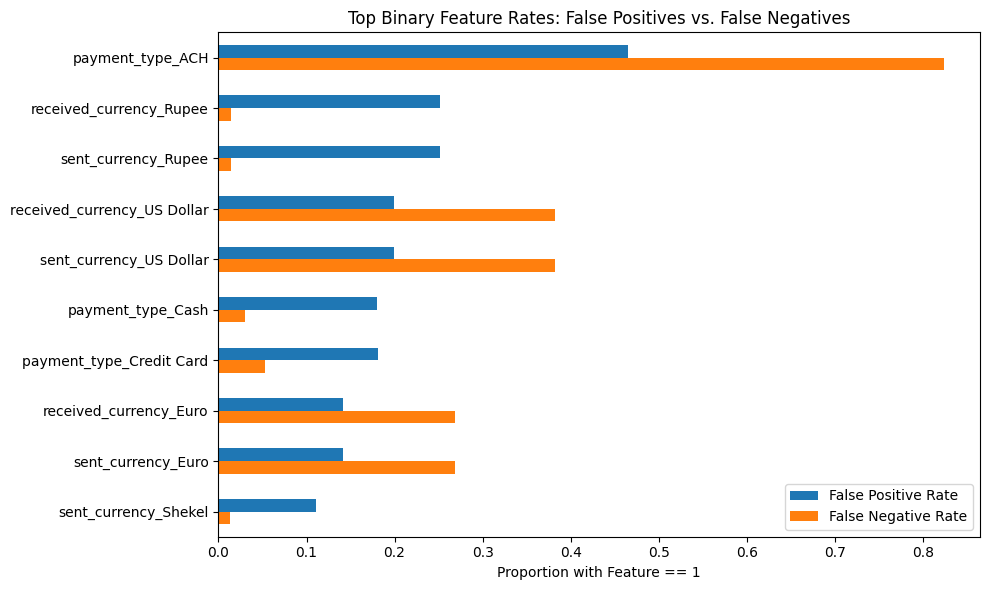

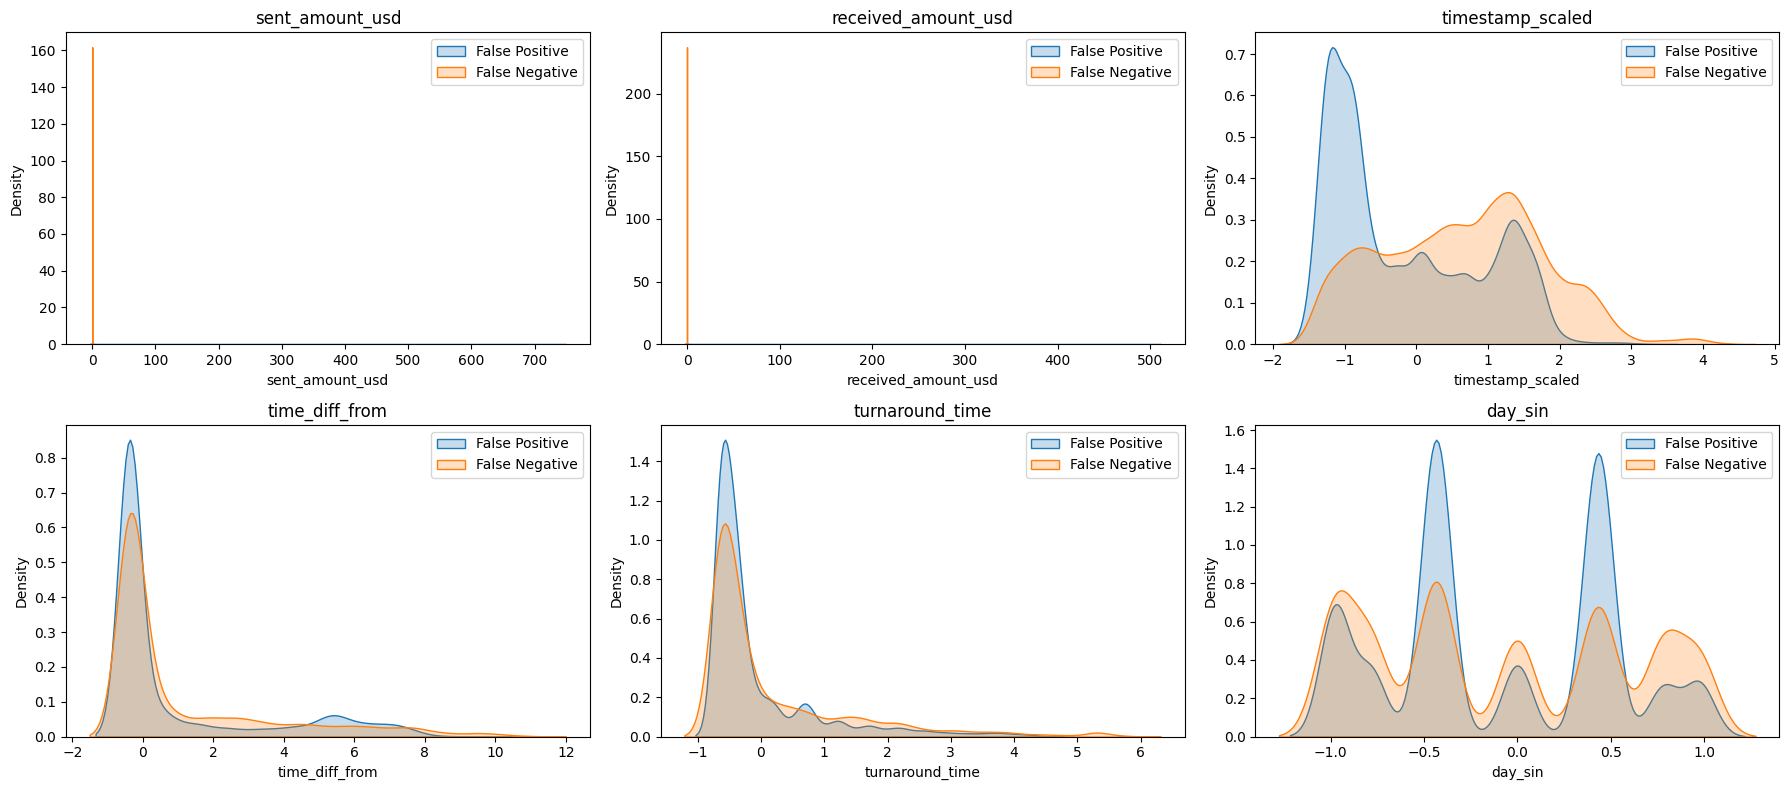


⏱️ Execution time: 9.41s


In [ ]:
# Identify binary features (those with only two unique values: 0 and 1)
binary_features = ['currency_changed',
       'received_currency_Australian Dollar', 'received_currency_Bitcoin',
       'received_currency_Brazil Real', 'received_currency_Canadian Dollar',
       'received_currency_Euro', 'received_currency_Mexican Peso',
       'received_currency_Ruble', 'received_currency_Rupee',
       'received_currency_Saudi Riyal', 'received_currency_Shekel',
       'received_currency_Swiss Franc', 'received_currency_UK Pound',
       'received_currency_US Dollar', 'received_currency_Yen',
       'received_currency_Yuan', 'sent_currency_Australian Dollar',
       'sent_currency_Bitcoin', 'sent_currency_Brazil Real',
       'sent_currency_Canadian Dollar', 'sent_currency_Euro',
       'sent_currency_Mexican Peso', 'sent_currency_Ruble',
       'sent_currency_Rupee', 'sent_currency_Saudi Riyal',
       'sent_currency_Shekel', 'sent_currency_Swiss Franc',
       'sent_currency_UK Pound', 'sent_currency_US Dollar',
       'sent_currency_Yen', 'sent_currency_Yuan', 'payment_type_ACH',
       'payment_type_Bitcoin', 'payment_type_Cash', 'payment_type_Cheque',
       'payment_type_Credit Card', 'payment_type_Reinvestment',
       'payment_type_Wire']

# Separate subsets
false_positives = df_eval[(df_eval["pred"] == 1) & (df_eval["label"] == 0)]
false_negatives = df_eval[(df_eval["pred"] == 0) & (df_eval["label"] == 1)]

# Compare mean values of binary features for FP and FN
fp_means = false_positives[binary_features].mean().rename("False Positive Rate")
fn_means = false_negatives[binary_features].mean().rename("False Negative Rate")
comparison_df = pd.concat([fp_means, fn_means], axis=1)
comparison_df["Diff"] = (comparison_df["False Positive Rate"] - comparison_df["False Negative Rate"]).abs()
comparison_df_sorted = comparison_df.sort_values("Diff", ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the top 10 binary features by difference in FP and FN rate
top_binary = comparison_df_sorted.head(10)

plt.figure(figsize=(10, 6))
top_binary[["False Positive Rate", "False Negative Rate"]].plot(kind="barh", figsize=(10, 6))
plt.title("Top Binary Feature Rates: False Positives vs. False Negatives")
plt.xlabel("Proportion with Feature == 1")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

# Identify continuous features (float or int types, excluding edge_id)
continuous_features = ['sent_amount_usd',
       'received_amount_usd', 'timestamp_scaled', 'time_diff_from',
       'turnaround_time', 'day_sin', 'day_cos', 'time_of_day_sin',
       'time_of_day_cos']

import seaborn as sns
import matplotlib.pyplot as plt

# Plot distributions for top continuous features (up to 6 for clarity)
top_cont = continuous_features[:6]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(top_cont):
    sns.kdeplot(false_positives[col], label="False Positive", ax=axes[i], fill=True)
    sns.kdeplot(false_negatives[col], label="False Negative", ax=axes[i], fill=True)
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
df_eval['sent_amount_usd'].describe()

,sent_amount_usd
count,8.564018e+06
mean,3.532239e+08
std,8.106277e+10
min,8.415672e-11
25%,2.116500e+02
50%,1.851175e+03
75%,2.959513e+04
max,4.870807e+13



⏱️ Execution time: 0.26s


# Alternative loss functions

In [ ]:
# # Use focal loss to focus on rare positives
# class FocalLoss(torch.nn.Module):
#     def __init__(self, gamma=2.0, alpha=0.25):
#         super().__init__()
#         self.gamma = gamma
#         self.alpha = alpha

#     def forward(self, logits, targets):
#         bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
#         pt = torch.exp(-bce_loss)  # Probabilities of correct classification
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
#         return focal_loss.mean()

# class HybridLoss(torch.nn.Module):
#     """Hybrid Loss that balances BCE (for accuracy) and Focal Loss (for recall)"""
#     def __init__(self, alpha=0.25, gamma=2.0, focal_weight=0.5):
#         super().__init__()
#         self.bce = torch.nn.BCEWithLogitsLoss()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.focal_weight = focal_weight  # Weighting factor between BCE and Focal Loss

#     def forward(self, logits, targets):
#         # BCE Loss
#         bce_loss = self.bce(logits, targets.float())

#         # Focal Loss
#         probs = torch.sigmoid(logits)
#         bce_loss_per_sample = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction="none")
#         focal_loss = self.alpha * (1 - torch.exp(-bce_loss_per_sample)) ** self.gamma * bce_loss_per_sample
#         focal_loss = focal_loss.mean()

#         # Combine BCE and Focal Loss
#         total_loss = (1 - self.focal_weight) * bce_loss + self.focal_weight * focal_loss
#         return total_loss

# criterion = FocalLoss(gamma=2.0, alpha=0.25)
#criterion = HybridLoss(focal_weight=0.3)  # Adjust weight (0.3-0.6 works well)